1. Read in the data
2. Make discriminator (model)
3. Make Generator (model)
4. Make loss functions for both



In [1]:
import fastbook
from fastbook import *
#import torch
#print(torch.cuda.is_available())
import re
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import gc
from PIL import Image

C:\Users\zeusg\Envs\real-fast\lib\site-packages\fastbook\__init__.py:19: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [2]:
%matplotlib inline

In [3]:
test = "blues.00000.wav.png"
a = re.findall(r'^([^.]+)', test)
a

['blues']

In [4]:
path = Path.BASE_PATH = r"D:\\DataSets\\Data\\genres_original\\all"

music = DataBlock(blocks = (ImageBlock(cls=PILImageBW), CategoryBlock),
        get_items= get_image_files,
        splitter = RandomSplitter(seed=42),
        get_y = using_attr(RegexLabeller(r'^([^.]+)'), 'name'))
dls = music.dataloaders(path, bs=4)
dls

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [5]:
music.summary(path)

Setting-up type transforms pipelines
Found 996 items
2 datasets of sizes 797,199
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      D:\DataSets\Data\genres_original\all\disco.00038.wav.png
    applying PILBase.create gives
      PILImageBW mode=L size=854x63
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      D:\DataSets\Data\genres_original\all\disco.00038.wav.png
    applying partial gives
      disco
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(3)

Final sample: (PILImageBW mode=L size=854x63, TensorCategory(3))


Found 996 items
2 datasets of sizes 797,199
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Due to IPython and Windows limitation, pyt

In [6]:

#torch.cuda.empty_cache()
#dls.show_batch(nrows=2, ncols=2)
#dls.show_batch(max_n=9, figsize=(8,6))


def clear_memory():
    gc.collect()
    torch.cuda.empty_cache()

# Discriminator

In [7]:
torch.cuda.empty_cache()
batch_x,y = dls.valid.one_batch()
x, y = batch_x.cuda(), y.cuda()
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(204480, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        
    def forward(self, image):
        return self.discriminator(image)

discriminator = Discriminator().cuda()
out = discriminator(batch_x)


In [8]:
clear_memory()

# Generator

In [9]:
#854x63 53802
class Generator(nn.Module):
    def __init__(self, z_dim=10):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.Linear(10,100),
            nn.Linear(100,1000),
            nn.Linear(1000,10000),
            nn.Linear(10000,53802),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.generator(x)


#x = torch.rand(4, 10).cuda()
#gen = Generator().cuda()
#y = gen(x)
#del y
#clear_memory()

## Discriminator Loss

In [10]:
def get_noise(num_images, z_dim, device="cuda"):
    noise = None
    if device == "cuda":
        noise = torch.rand(num_images,z_dim , device=device).cuda()
    else:
        noise = torch.rand(num_images, z_dim)
    return noise


In [11]:
def get_disc_loss(gen, disc, criterion, real_input, num_images, z_dim, device="cuda"):
    '''
    Return Loss of discriminator 
    Params: 
    Gen: Geneartor model
    Disc: Discrimiator Model
    criterion: Loss function
    Real Input: Our data set images
    Num_images: Len(real input)
    z_dim: Dimention of our noise vector
    Return a loss value for 1 batch
    '''
    
    fake_images = gen(get_noise(num_images, z_dim, device=device))
    fake_images = torch.reshape(fake_images, (4, 1, 63, 854))
    fake_images.detach()
    fake_loss = criterion(disc(fake_images), torch.zeros((num_images,1),device=device))
    real_loss = criterion(disc(real_input), torch.ones((num_images,1),device=device))
    disc_loss = fake_loss + real_loss/2
    del fake_loss
    del real_loss
    del fake_images
    clear_memory()
    return disc_loss

def test_disc():
    gen = Generator().cuda()
    disc = Discriminator().cuda()
    criterion = nn.BCEWithLogitsLoss()
    x,y = dls.valid.one_batch()
    num_images = len(x)
    z_dim = 10
    loss = get_disc_loss(gen, disc, criterion, x, num_images, z_dim)
    return loss
    
#loss = test_disc()
#print(loss)


# Generator Loss

In [16]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device="cuda"):
    '''
    Returns the loss of the generator
    Params: 
    Gen: Generator Model
    Disc: Discrimiator Model
    Criterion: Loss Function
    num_images: The number of images the generator should produce
    z_dim: The dim of the noise vector
    Device: What device we run it on
    '''
    fake_images = gen(get_noise(num_images, z_dim, device=device))
    fake_images = torch.reshape(fake_images, (4, 1, 63, 854))
    prediction = disc(fake_images)
    gen_loss = criterion(prediction, torch.ones(num_images,1, device=device))
    del fake_images
    del prediction
    clear_memory()
    return gen_loss

def test_gen_loss():
    gen = Generator().cuda()
    disc = Discriminator().cuda()
    criterion = nn.BCEWithLogitsLoss()
    num_images = 4 
    z_dim = 10
    loss = get_gen_loss(gen, disc, criterion, num_images, z_dim)
    return loss

loss = test_gen_loss()
print(loss)
#loss = None

tensor(0.4835, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


# Training

In [14]:
clear_memory()

In [15]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 5
z_dim = 10
#batch_size = 4

device = "cuda"
#device = "cpu"
gen = Generator().to(device)
gen_opt = torch.optim.Adam(gen.parameters())
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters())

cur_step = 0 
disc_loss_hist = [] 
gen_loss_hist = []


for epoch in range(n_epochs):
    disc_loss_batch = 0.0
    gen_loss_batch = 0.0
    batch_size = len(dls.train)
    for batch in dls.train:
        real_images, *_ = batch
        real_images = real_images.to(device)
        num_images = len(real_images)
        #Train discriminator
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real_images, num_images, z_dim, device)
        disc_loss_batch+=float(disc_loss_hist)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        #Train Generator
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, num_images, z_dim, device)
        gen_loss_batch+=float(gen_loss)
        gen_loss.backward(retain_graph=True)
        gen_opt.step()
        del real_images
        del num_images
        del gen_loss
        del disc_loss
        clear_memory()
    disc_loss_hist.append(disc_loss_batch/batch_size)
    gen_loss_hist.append(gen_loss_batch/batch_size)

        
        

RuntimeError: CUDA out of memory. Tried to allocate 2.01 GiB (GPU 0; 8.00 GiB total capacity; 4.66 GiB already allocated; 953.42 MiB free; 4.74 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# TODO
1. ~~Make list~~
2. [Get GPU working?](https://pytorch.org/docs/stable/notes/faq.html)
3. Change model for generator Transposed convolution
4. Increase image resolution 
5. "Tunning" 

    a. Stride

    b. CNN Nonsense

1. Test on your machine
2. reduce linear layers size
3. Consolidate loss functions

In [79]:
a=5
a+=10
a

15

C:\Users\zeusg\AppData\Local\Temp/ipykernel_37716/1036642471.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


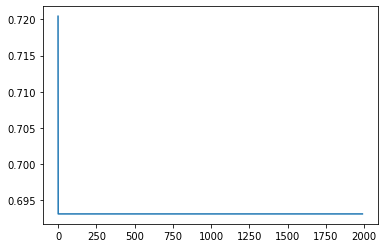

In [70]:
fig,ax = plt.subplots()
ax.plot(disc_loss_hist)
fig.show()

In [71]:
def make_image(gen):
    x = torch.rand(4, 10)
    y = gen(x)
    return y
y = make_image(gen)
image = torch.reshape(y, (4, 1, 63, 854))


In [72]:
y = y.detach().numpy() 
y.ndim

2

In [73]:
image = image[0,0].detach().numpy() 

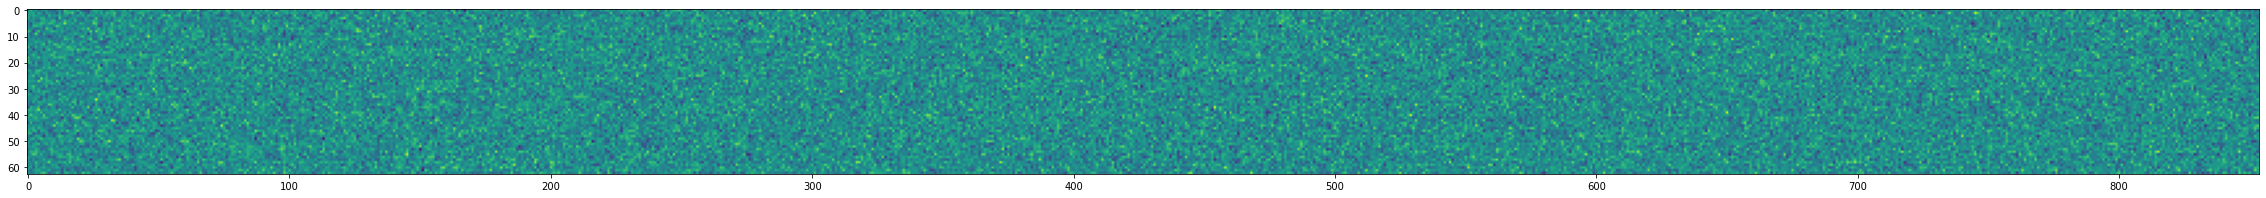

In [74]:
plt.figure(figsize=(40,10))
plt.imshow(image)

In [31]:
im = Image.fromarray(image).convert('RGB')
im.save("Generated.jpeg")